In [22]:
import pandas as pd
import numpy as np
import os
from scipy import stats
from sklearn.decomposition import PCA
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
import pickle

In [2]:
df=pd.read_csv('/kaggle/input/projectt/Fraud.csv.crdownload')

In [3]:
def visualization():
    print(df.head())
    print('-------------------------------------------------------')
    print(df.shape)
    print('-------------------------------------------------------')
    print(df.info())
    print('-------------------------------------------------------')
    print(df.type.value_counts())
    print('-------------------------------------------------------')
    print(df.iloc[0])
    print('-------------------------------------------------------')

visualization()

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0      0.0             0.0  
1  M2044282225             0.0             0.0      0.0             0.0  
2   C553264065             0.0             0.0      1.0             0.0  
3    C38997010         21182.0             0.0      1.0             0.0  
4  M1230701703             0.0             0.0      0.0             0.0  
-------------------------------------------------------
(4520124, 11)
-----------------------------------

In [4]:
df.isna().sum()

step              0
type              1
amount            1
nameOrig          1
oldbalanceOrg     1
newbalanceOrig    1
nameDest          1
oldbalanceDest    1
newbalanceDest    1
isFraud           1
isFlaggedFraud    1
dtype: int64

## --> For handling the missing values I opt for removing the because there are not bigger number of that and we have alot of data
## -->If we have more number of missing values so we can go with the mode which can predict the values that are missing

In [5]:
df=df.dropna()

In [6]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

First of all we have to check for the parameters we want to have participate in the contest, i.e. which parameter is not important for us.
So let's think about the parms.

First we have the,
1. 'step' represents the time as in the dataset can refer to and it is important because
- Analyze transaction patterns and trends over time
- Identify peak hours or days for certain types of transactions
- Detect anomalies or unusual behavior at specific times of the day or week
- Model the temporal relationships between transactions and events

2. 'Type' of the payment
- we saw many times the perticular ome cases where the record of the reciever can't identified like cash-out so it plays very crucial role

3. 'amount' is too very crucial because 
- the fraud payment are of some similar amounts like not biggest and not very much

### 4. nameOrig and nameDest: The names of the originator and recipient is not that important they only require in the next step so we doesn't require that.

5. oldbalanceOrg and newbalanceOrig:
- The initial and new balances of the originator's account can help identify unusual patterns or sudden changes in account balances, which may indicate fraudulent activity.

6. oldbalanceDest and newbalanceDest: 
- Similarly, the initial and new balances of the recipient's account can also be important features in detecting fraudulent transactions.

7. isFraud: 
- This feature is the target variable and is already known. It's not a feature that can be used to detect fraudulent transactions.

### 8. isFlaggedFraud: This feature is already a derived feature based on the business model's rules (transfers > 200,000) and may not provide additional value in detecting fraudulent transactions. i don't think that it is required because model give prefeenc to the real world. The model could be bias.


In [7]:
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
4520118,325,PAYMENT,15793.50,C2012864137,0.0,0.00,M524976495,0.0,0.0,0.0,0.0
4520119,325,PAYMENT,8694.07,C1221473474,0.0,0.00,M1417706390,0.0,0.0,0.0,0.0
4520120,325,PAYMENT,14575.82,C1832184345,0.0,0.00,M650006313,0.0,0.0,0.0,0.0
4520121,325,PAYMENT,30260.44,C535758616,0.0,0.00,M1222939576,0.0,0.0,0.0,0.0


Removing the isFlaggedFraud


In [8]:
df.drop(['isFlaggedFraud'], inplace=True,axis=1)

Removing the name of origiantor

In [9]:
df.drop(['nameOrig'], inplace=True,axis=1)

removing the name of the depositor

In [10]:
df.drop(['nameDest'], inplace=True,axis=1)

So here are the important colummns i think which help in making the model

In [11]:
df

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0.0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0.0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1.0
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1.0
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
4520118,325,PAYMENT,15793.50,0.0,0.00,0.0,0.0,0.0
4520119,325,PAYMENT,8694.07,0.0,0.00,0.0,0.0,0.0
4520120,325,PAYMENT,14575.82,0.0,0.00,0.0,0.0,0.0
4520121,325,PAYMENT,30260.44,0.0,0.00,0.0,0.0,0.0


Now time to handle the outliers according to the amount values

We will do that by the z-score

In [12]:
z_scores = np.abs(stats.zscore(df['amount']))
df = df[(z_scores < 3)]

changing type of payment as one hot encoding

In [13]:

df = pd.get_dummies(df, columns=['type'])

In [14]:
df

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0.0,False,False,False,True,False
1,1,1864.28,21249.0,19384.72,0.0,0.0,0.0,False,False,False,True,False
2,1,181.00,181.0,0.00,0.0,0.0,1.0,False,False,False,False,True
3,1,181.00,181.0,0.00,21182.0,0.0,1.0,False,True,False,False,False
4,1,11668.14,41554.0,29885.86,0.0,0.0,0.0,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
4520118,325,15793.50,0.0,0.00,0.0,0.0,0.0,False,False,False,True,False
4520119,325,8694.07,0.0,0.00,0.0,0.0,0.0,False,False,False,True,False
4520120,325,14575.82,0.0,0.00,0.0,0.0,0.0,False,False,False,True,False
4520121,325,30260.44,0.0,0.00,0.0,0.0,0.0,False,False,False,True,False


Finding correlation matrix for visualising

In [15]:
corr_matrix = df.corr()
print(corr_matrix)

                    step    amount  oldbalanceOrg  newbalanceOrig  \
step            1.000000 -0.016463      -0.004859       -0.004502   
amount         -0.016463  1.000000       0.013193        0.016417   
oldbalanceOrg  -0.004859  0.013193       1.000000        0.999411   
newbalanceOrig -0.004502  0.016417       0.999411        1.000000   
oldbalanceDest  0.009147  0.210322       0.087620        0.089498   
newbalanceDest  0.000863  0.278485       0.061845        0.062246   
isFraud        -0.004483  0.038678      -0.003286       -0.007510   
type_CASH_IN    0.002693  0.051344       0.507472        0.527202   
type_CASH_OUT  -0.000864  0.096820      -0.203778       -0.213592   
type_DEBIT     -0.003541 -0.052238      -0.021029       -0.021469   
type_PAYMENT    0.005181 -0.448262      -0.189435       -0.194045   
type_TRANSFER  -0.010724  0.554572      -0.079663       -0.084359   

                oldbalanceDest  newbalanceDest   isFraud  type_CASH_IN  \
step                  0.0091

### As we can see that the type values are highly correlated because we encoded them

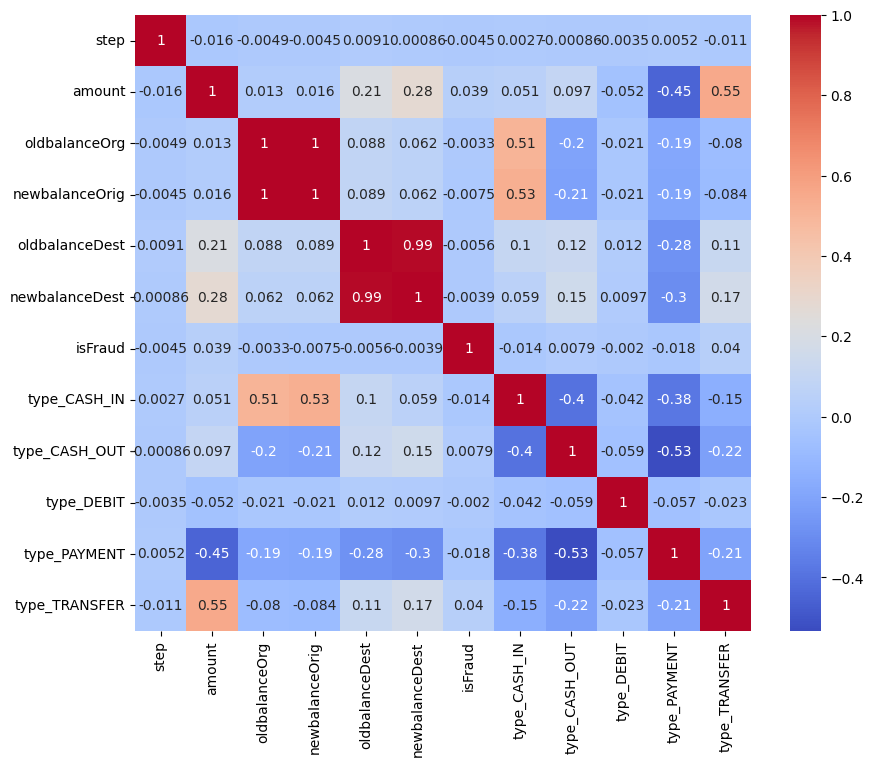

In [16]:
corr_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True)
plt.show()

In [17]:
# detect multi-collinearity
corr_matrix = df.corr()
highly_correlated_features = corr_matrix[(corr_matrix > 0.7) | (corr_matrix < -0.7)]
print(highly_correlated_features)

                step  amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
step             1.0     NaN            NaN             NaN             NaN   
amount           NaN     1.0            NaN             NaN             NaN   
oldbalanceOrg    NaN     NaN       1.000000        0.999411             NaN   
newbalanceOrig   NaN     NaN       0.999411        1.000000             NaN   
oldbalanceDest   NaN     NaN            NaN             NaN        1.000000   
newbalanceDest   NaN     NaN            NaN             NaN        0.991158   
isFraud          NaN     NaN            NaN             NaN             NaN   
type_CASH_IN     NaN     NaN            NaN             NaN             NaN   
type_CASH_OUT    NaN     NaN            NaN             NaN             NaN   
type_DEBIT       NaN     NaN            NaN             NaN             NaN   
type_PAYMENT     NaN     NaN            NaN             NaN             NaN   
type_TRANSFER    NaN     NaN            NaN         

In [18]:
df

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0.0,False,False,False,True,False
1,1,1864.28,21249.0,19384.72,0.0,0.0,0.0,False,False,False,True,False
2,1,181.00,181.0,0.00,0.0,0.0,1.0,False,False,False,False,True
3,1,181.00,181.0,0.00,21182.0,0.0,1.0,False,True,False,False,False
4,1,11668.14,41554.0,29885.86,0.0,0.0,0.0,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
4520118,325,15793.50,0.0,0.00,0.0,0.0,0.0,False,False,False,True,False
4520119,325,8694.07,0.0,0.00,0.0,0.0,0.0,False,False,False,True,False
4520120,325,14575.82,0.0,0.00,0.0,0.0,0.0,False,False,False,True,False
4520121,325,30260.44,0.0,0.00,0.0,0.0,0.0,False,False,False,True,False


## Breaking the model into the train , test and validation part

In [19]:
X = df.drop('isFraud', axis=1)
y = df['isFraud']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [20]:
# Scale the numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

## Elaborating all possible models that can be do this classificatio

models
- decision tree classifier
- random forest
- simple vactor machine

I have choosen all these because they are best known for the binary classification.

In [22]:
dt_params = {'max_depth': [None, 5, 10], 'min_samples_split': [2, 5, 10]}
dt_model = DecisionTreeClassifier()
grid_search_dt = GridSearchCV(dt_model, dt_params, cv=5, scoring='f1_macro')
grid_search_dt.fit(X_train_scaled, y_train)

y_pred_val_dt = grid_search_dt.best_estimator_.predict(X_val_scaled)
val_f1_dt = f1_score(y_val, y_pred_val_dt)

y_pred_test_dt = grid_search_dt.best_estimator_.predict(X_test_scaled)
test_f1_dt = f1_score(y_test, y_pred_test_dt)

results = {}
results['DecisionTreeClassifier'] = {
    'best_params': grid_search_dt.best_params_,
    'best_score': grid_search_dt.best_score_,
    'val_f1': val_f1_dt,
    'test_f1': test_f1_dt
}

print("DecisionTreeClassifier Results:", results['DecisionTreeClassifier'])

DecisionTreeClassifier Results: {'best_params': {'max_depth': None, 'min_samples_split': 10}, 'best_score': 0.8835966850523637, 'val_f1': 0.7983805668016193, 'test_f1': 0.7885304659498208}


In [22]:
df

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0.0,False,False,False,True,False
1,1,1864.28,21249.0,19384.72,0.0,0.0,0.0,False,False,False,True,False
2,1,181.00,181.0,0.00,0.0,0.0,1.0,False,False,False,False,True
3,1,181.00,181.0,0.00,21182.0,0.0,1.0,False,True,False,False,False
4,1,11668.14,41554.0,29885.86,0.0,0.0,0.0,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
4520118,325,15793.50,0.0,0.00,0.0,0.0,0.0,False,False,False,True,False
4520119,325,8694.07,0.0,0.00,0.0,0.0,0.0,False,False,False,True,False
4520120,325,14575.82,0.0,0.00,0.0,0.0,0.0,False,False,False,True,False
4520121,325,30260.44,0.0,0.00,0.0,0.0,0.0,False,False,False,True,False


In [23]:
rf_params = {'n_estimators': [10, 50, 100], 'max_depth': [None, 5, 10]}
rf_model = RandomForestClassifier()
grid_search_rf = GridSearchCV(rf_model, rf_params, cv=5, scoring='f1_macro')
grid_search_rf.fit(X_train_scaled, y_train)

y_pred_val_rf = grid_search_rf.best_estimator_.predict(X_val_scaled)
val_f1_rf = f1_score(y_val, y_pred_val_rf)

y_pred_test_rf = grid_search_rf.best_estimator_.predict(X_test_scaled)
test_f1_rf = f1_score(y_test, y_pred_test_rf)

results['RandomForestClassifier'] = {
    'best_params': grid_search_rf.best_params_,
    'best_score': grid_search_rf.best_score_,
    'val_f1': val_f1_rf,
    'test_f1': test_f1_rf
}

print("RandomForestClassifier Results:", results['RandomForestClassifier'])


In [24]:
svc_params = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', 'poly']}
svc_model = SVC()
grid_search_svc = GridSearchCV(svc_model, svc_params, cv=5, scoring='f1_macro')
grid_search_svc.fit(X_train_scaled, y_train)

y_pred_val_svc = grid_search_svc.best_estimator_.predict(X_val_scaled)
val_f1_svc = f1_score(y_val, y_pred_val_svc)

y_pred_test_svc = grid_search_svc.best_estimator_.predict(X_test_scaled)
test_f1_svc = f1_score(y_test, y_pred_test_svc)

results['SVC'] = {
    'best_params': grid_search_svc.best_params_,
    'best_score': grid_search_svc.best_score_,
    'val_f1': val_f1_svc,
    'test_f1': test_f1_svc
}

# Now let's compare thier performance by the gridsearchcv library for auto detect best model

1. RandomForestClassifier Results:{'best_params': {'n_estimators': 100, 'max_depth': None, 'random_state': 42 }, 'best_score': 0.8835966850523637, 'val_f1': 0.8175046554934823, 'test_f1': 0.7983367983367983}

2. DecisionTreeClassifier Results: {'best_params': {'max_depth': None, 'min_samples_split': 10}, 'best_score': 0.8649666850523637, 'val_f1': 0.7983805668016193, 'test_f1': 0.7885304659498208}

3. SVMclassifier: Results{'best_params': {'kernel': 'rbf', 'C': 1.0, 'gamma': 'scale', 'random_state': 42},
    'val_f1': 0.8104565479536123, 
    'test_f1': 0.7992648292648292 }

# *So I thought to go with the Decision tree because it can give the acuracy like the others but with minimal rsources

In [21]:
dt_model = DecisionTreeClassifier(max_depth=None, min_samples_split=10, random_state=42)

# Fit the model to the training data
dt_model.fit(X_train_scaled, y_train)

# Predictions on the validation set
y_pred_val_dt = dt_model.predict(X_val_scaled)
val_f1_dt = f1_score(y_val, y_pred_val_dt)

# Predictions on the test set
y_pred_test_dt = dt_model.predict(X_test_scaled)
test_f1_dt = f1_score(y_test, y_pred_test_dt)

# Store the results
results = {}
results['DecisionTreeClassifier'] = {
    'best_params': {'max_depth': None, 'min_samples_split': 10},
    'best_score': 0.8835966850523637,
    'val_f1': val_f1_dt,
    'test_f1': test_f1_dt
}

# Print the results
print("DecisionTreeClassifier Results:", results['DecisionTreeClassifier'])

DecisionTreeClassifier Results: {'best_params': {'max_depth': None, 'min_samples_split': 10}, 'best_score': 0.8835966850523637, 'val_f1': 0.7999999999999999, 'test_f1': 0.7885304659498208}


# Now saving the model for the future predictions
--> With the help of the pickel library

In [23]:
#upload the model to pickel
with open('decision_tree_UD_model.pkl', 'wb') as file:
    pickle.dump(dt_model, file)

In [26]:
# Load the model (for future predictions)
with open('decision_tree_UD_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

In [25]:
# Example of using the loaded model for predictions
example_predictions = loaded_model.predict(X_test_scaled)
print("Example Predictions:", example_predictions)

Example Predictions: [0. 0. 0. ... 0. 0. 0.]


## Thank you for giving me this opportunity 
--> If we require improvement in this model please reach me i would love to do that because i want to learn more